In [130]:
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

In [118]:
full_df=pd.read_csv('/content/NAV_EPS.csv')
full_df.head()

,Name,Performance Year,Basic EPS Based On Continuous operations,Basic EPS Based On Including Extra-Ordinary Income,Basic EPS (restated) Based On Continuous operations,Basic EPS (restated) Based On Including Extra-Ordinary Income,Net Asset Value Per Share,Restated Net Asset Value Per Share,Net Profit After Tax Continuous operations (mn),Net Profit After Tax Including Extra-Ordinary Income (mn),% Dividend,% Dividend Yield
0,AAMRA NETWORKS LIMITED,2024,2.46,0,0.0,0,37.01,0.0,228.75,0,10%C,3.01
1,AAMRA NETWORKS LIMITED,2023,3.64,0,0.0,0,38.11,0.0,225.67,0,11%C,1.55
2,AAMRA NETWORKS LIMITED,2022,1.85,0,0.0,0,36.70,0.0,109.29,0,"5%C, 5%B",0.00
3,AAMRA NETWORKS LIMITED,2021,2.14,0,0.0,0,37.09,0.0,120.39,0,"5%C, 5%B",1.23
4,AAMRA NETWORKS LIMITED,2020,3.19,0,0.0,0,35.95,0.0,179.45,0,10%C,3.01


In [119]:
full_df.dtypes



,0
Name,object
Performance Year,int64
Basic EPS Based On Continuous operations,float64
Basic EPS Based On Including Extra-Ordinary Income,int64
Basic EPS (restated) Based On Continuous operations,float64
Basic EPS (restated) Based On Including Extra-Ordinary Income,int64
Net Asset Value Per Share,float64
Restated Net Asset Value Per Share,float64
Net Profit After Tax Continuous operations (mn),float64
Net Profit After Tax Including Extra-Ordinary Income (mn),int64


In [120]:
full_df.shape


(1789, 12)

In [121]:
df=full_df.copy()

In [122]:
#extracting cash and bonus dividend
df['% Cash Dividend'] = (df['% Dividend'].astype(str).str.extract(r'(\d+\.?\d*)%C')[0].fillna(0) )
df['% Cash Dividend'] = pd.to_numeric(df['% Cash Dividend'])

df['% Bonus Dividend'] = (df['% Dividend'].astype(str).str.extract(r'(\d+\.?\d*)%B')[0].fillna(0) )
df['% Bonus Dividend'] = pd.to_numeric(df['% Bonus Dividend'])

print(df[['% Dividend', '% Cash Dividend','% Bonus Dividend']].head())

  % Dividend  % Cash Dividend  % Bonus Dividend
0       10%C             10.0               0.0
1       11%C             11.0               0.0
2   5%C, 5%B              5.0               5.0
3   5%C, 5%B              5.0               5.0
4       10%C             10.0               0.0


In [123]:
#cleaning year wise, Dividend Yield and Cash Dividend

# companies with all 5 years
performance_year = [2020, 2021, 2022, 2023, 2024]
df = df[df['Performance Year'].isin(performance_year)]
valid_years = df.groupby("Name")["Performance Year"].nunique()
valid_years = valid_years[valid_years == len(performance_year)].index

# dividend yield > 0
valid_div_yield = df.groupby("Name")["% Dividend Yield"].min()
valid_div_yield = valid_div_yield[valid_div_yield > 0].index

# cash dividend > 0
valid_cash_div = df.groupby("Name")["% Cash Dividend"].min()
valid_cash_div = valid_cash_div[valid_cash_div > 0].index

valid_companies = set(valid_years) & set(valid_div_yield) & set(valid_cash_div)

df = df[df["Name"].isin(valid_companies)].reset_index(drop=True)

print("Remaining companies:", len(valid_companies))
print("Remaining rows:", len(df))


Remaining companies: 128
Remaining rows: 640


In [124]:
#actual eps
df['EPS']=df['Basic EPS Based On Continuous operations']- (df['Basic EPS Based On Continuous operations']*(df['% Bonus Dividend']/100))
#actual nav
df['NAV'] = df['Net Asset Value Per Share']- (df['Net Asset Value Per Share']*(df['% Bonus Dividend']/100))

print(df[['% Bonus Dividend','Net Asset Value Per Share','NAV', 'Basic EPS Based On Continuous operations','EPS']].head())

   % Bonus Dividend  Net Asset Value Per Share      NAV  \
0               0.0                      21.73  21.7300   
1               0.0                      22.85  22.8500   
2               6.0                      24.09  22.6446   
3               5.0                      23.93  22.7335   
4               0.0                      23.48  23.4800   

   Basic EPS Based On Continuous operations     EPS  
0                                     -0.12 -0.1200  
1                                      0.70  0.7000  
2                                      1.78  1.6732  
3                                      1.45  1.3775  
4                                      1.46  1.4600  


In [125]:
#all shares face value is 10, and the cash dividend is calculated based on 10
#cash dividend= 10 * given%
#price=(cash dividend/Dividend Yeild)*100

df['Price']=((((10*(df['% Cash Dividend']/100) )) / df['% Dividend Yield'])*100)*(1-df['% Bonus Dividend']/100)
print(df[['% Cash Dividend','% Dividend Yield', 'Price',]].head())

   % Cash Dividend  % Dividend Yield      Price
0              1.0              0.46  21.739130
1             10.0              2.72  36.764706
2              6.0              1.82  30.989011
3              5.0              1.91  24.869110
4             10.0              4.35  22.988506


In [126]:
# correlation of Price vs EPS per company
df['Price Vs EPS Correlation'] = (
    df.groupby("Name")
      .apply(lambda g: g['Price'].corr(g['EPS']))
      .reindex(df['Name']).values
)

# correlation of Price vs NAV per company
df['Price Vs NAV Correlation'] = (
    df.groupby("Name")
      .apply(lambda g: g['Price'].corr(g['NAV']))
      .reindex(df['Name']).values
)

print(df[['Name','Price','EPS','NAV',
          'Price Vs EPS Correlation',
          'Price Vs NAV Correlation']].head())


                      Name      Price     EPS      NAV  \
0  AAMRA TECHNOLOGIES LTD.  21.739130 -0.1200  21.7300   
1  AAMRA TECHNOLOGIES LTD.  36.764706  0.7000  22.8500   
2  AAMRA TECHNOLOGIES LTD.  30.989011  1.6732  22.6446   
3  AAMRA TECHNOLOGIES LTD.  24.869110  1.3775  22.7335   
4  AAMRA TECHNOLOGIES LTD.  22.988506  1.4600  23.4800   

   Price Vs EPS Correlation  Price Vs NAV Correlation  
0                  0.160135                  0.200989  
1                  0.160135                  0.200989  
2                  0.160135                  0.200989  
3                  0.160135                  0.200989  
4                  0.160135                  0.200989  


/tmp/ipython-input-678974995.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g['Price'].corr(g['EPS']))
/tmp/ipython-input-678974995.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g['Price'].corr(g['NAV']))


In [127]:
df['Efficient(EPS)'] = np.where(df['Price Vs EPS Correlation'] > 0, 'Yes', 'No')
df['Efficient(NAV)'] = np.where(df['Price Vs NAV Correlation'] > 0, 'Yes', 'No')

print(df[['Name','Price','EPS','NAV','Price Vs EPS Correlation','Price Vs NAV Correlation','Efficient(EPS)','Efficient(NAV)']].head())

                      Name      Price     EPS      NAV  \
0  AAMRA TECHNOLOGIES LTD.  21.739130 -0.1200  21.7300   
1  AAMRA TECHNOLOGIES LTD.  36.764706  0.7000  22.8500   
2  AAMRA TECHNOLOGIES LTD.  30.989011  1.6732  22.6446   
3  AAMRA TECHNOLOGIES LTD.  24.869110  1.3775  22.7335   
4  AAMRA TECHNOLOGIES LTD.  22.988506  1.4600  23.4800   

   Price Vs EPS Correlation  Price Vs NAV Correlation Efficient(EPS)  \
0                  0.160135                  0.200989            Yes   
1                  0.160135                  0.200989            Yes   
2                  0.160135                  0.200989            Yes   
3                  0.160135                  0.200989            Yes   
4                  0.160135                  0.200989            Yes   

  Efficient(NAV)  
0            Yes  
1            Yes  
2            Yes  
3            Yes  
4            Yes  


In [128]:
df.to_csv('Efficient_Pricing.csv')
files.download('Efficient_Pricing.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [129]:
# Efficient Based on EPS
efficient_eps_count = len(df[df['Efficient(EPS)'] == 'Yes'])
efficicent_eps = (efficient_eps_count / len(df)) * 100
inefficicent_eps = 100 - efficicent_eps

# Efficient Based on NAV
efficient_nav_count = len(df[df['Efficient(NAV)'] == 'Yes'])
efficicent_nav = (efficient_nav_count / len(df)) * 100
inefficicent_nav = 100 - efficicent_nav

print(f"Efficient EPS: {efficicent_eps:.2f}% | Inefficient EPS: {inefficicent_eps:.2f}%")
print(f"Efficient NAV: {efficicent_nav:.2f}% | Inefficient NAV: {inefficicent_nav:.2f}%")



Efficient EPS: 82.81% | Inefficient EPS: 17.19%
Efficient NAV: 66.41% | Inefficient NAV: 33.59%


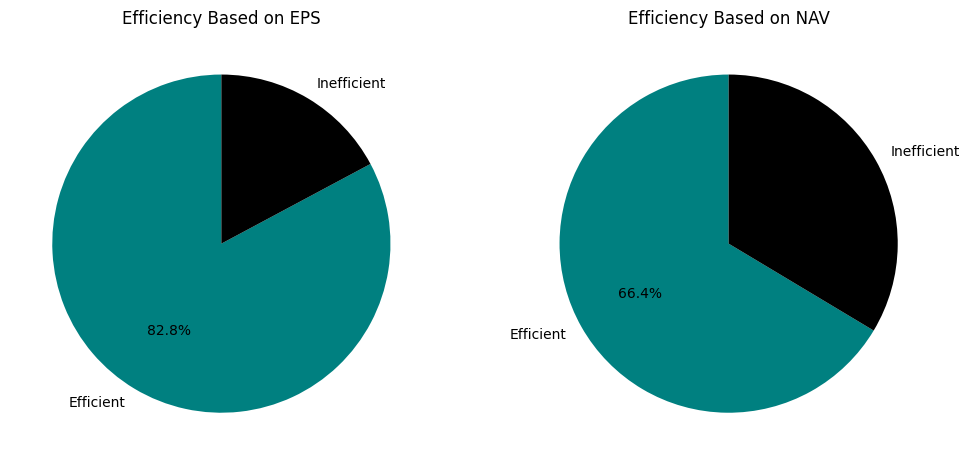

In [134]:
# pie chart

eps_labels = ['Efficient', 'Inefficient']
eps_sizes = [efficicent_eps, inefficicent_eps]
eps_colors = ['teal', 'black']

nav_labels = ['Efficient', 'Inefficient']
nav_sizes = [efficicent_nav, inefficicent_nav]
nav_colors =['teal', 'black']

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# EPS
axes[0].pie(eps_sizes, labels=eps_labels, autopct='%1.1f%%', startangle=90, colors=eps_colors)
axes[0].set_title('Efficiency Based on EPS')

# NAV
axes[1].pie(nav_sizes, labels=nav_labels, autopct='%1.1f%%', startangle=90, colors=nav_colors)
axes[1].set_title('Efficiency Based on NAV')

plt.show()


Result Aanalysis:
The result shows that according to EPS 83% of the market is efficiently priced, that is increase in earnning is reflected through an increase in price of the share. Same study run through NAV shows a 66% correlation, the lower correlation in NAV can be explained by the fact that increase in valuation of land or  immovable assets of such does not always result in increased productivity of the company. Hence, price change due to NAV would reflect a stronger correlation only in longer time frames.However, the market still suggests a 17% inefficient pricing of securities, which leaves room  for some short term trading gains.